# Fitting a generative model using standard divergences between measures

In this notebook, 




In [21]:
# Import the standard array-related libraries (MATLAB-like)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from   matplotlib.collections  import LineCollection
%matplotlib nbagg
plt.ion()

In [22]:
# Import the automatic differentiation + GPU toolbox
import torch
from torch          import nn
from torch.nn       import Parameter
from torch.autograd import Variable

In [23]:
# Shall we use the GPU?
use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
NPOINTS  = 200 if use_cuda else 50

## A GMM-polynomial generative model

In [24]:
def PolynomialMapping( coeffs, T ) :
    """
    Given 
    """
    X = Variable(torch.zeros( 2, len(T) ).type(dtype))
    for (d, c) in enumerate(coeffs) :
        X += c.view(2,1) * ( T.view(1,len(T)) )**d
    return X.t()

In [25]:
class GenerativeModel(nn.Module) :
    """
    This Model generates discrete measures in the plane R^2, according to
    the following process:
    - a 
    
    This class can therefore be seen as a differentiable implementation
    of a Gaussian Mixture Model in R, embedded in the plane by a polynomial
    mapping.
    
    Even though this notebook is not dedicated to "Neural Networks",
    we use the convenient syntax introduced by nn.Module and nn.Parameter.
    """
    def __init__(self, p = None, sigmas = None, coeffs = None, degree = 1) :
        "Defines the parameters of the model, using default values if necessary."
        super(GenerativeModel, self).__init__()
        if p      is None : p      = [0]
        if sigmas is None : sigmas = [.1,.1]
        if coeffs is None : coeffs = [[.1]*(degree+1), [.1]*(degree+1)]
            
        self.p      = Parameter(torch.from_numpy(np.array(p     )).type(dtype))
        self.sigmas = Parameter(torch.from_numpy(np.array(sigmas)).type(dtype))
        self.coeffs = Parameter(torch.from_numpy(np.array(coeffs).T).type(dtype))

    def forward(self, N) :
        """
        Assuming that N is an integer, generates:
        - a batch X_i of N points in the plane - an (N,2) array
        - a vector of weights M_i - an (N,) vector.
        The generated measure should be understood as being equal to
                Mu = \sum_i M_i*\delta_{X_i}
        """
        cut = N//2
        
        # Sample a Gaussian distribution, and distort it to end up on
        # the two normal laws N(-1, sigma_0), N(1, sigma_1)
        T = Variable(torch.normal( means = torch.zeros(N) ).type(dtype) )
        T = torch.cat( (self.sigmas[0] * T[:cut] - 1. ,
                        self.sigmas[1] * T[cut:] + 1. ) )
        
        # Map the 1D coefficients to the 2D plane through a polynomial mapping
        X = PolynomialMapping(self.coeffs, T)
        
        # Compute the weights associated to our diracs :
        # overall, mass P for the first cluster and 1-P for the second one.
        P = 1. / (1. + torch.exp(-self.p))
        W = torch.cat( ( (   P  / cut    ) * Variable(torch.ones(  cut).type(dtype)) ,
                         ((1-P) / (N-cut)) * Variable(torch.ones(N-cut).type(dtype)) ) )
        return W, X
    
    def plot(self, axis, color = 'b') :
        "Displays the curve associated to the underlying polynomial mapping."
        # (x(t),y(t)) for t in [-5,5]
        t = Variable(torch.linspace(-5,5,101).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.plot( X[:,0], X[:,1], color+'-+', markersize = 8, linewidth=.5, zorder=-1 )
        
        # Puts two large dots at the "centers" of both sigmoids
        t = Variable(torch.linspace(-1,1,2).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.scatter( X[:,0], X[:,1], 125, color, edgecolors='none' )

## Our toy dataset 

In [26]:
# Create a model: two unbalanced classes mapped through a polynomial curve of degree = 3
GroundTruth = GenerativeModel(p = [1.], sigmas = [.1,.2], coeffs = [[-.2,1,+.2,-.1], [-1.5,-.3,1.5,.5]])
# print(GroundTruth.coeffs) # Parameters of the model are easily accessible

In [27]:
# Sample our "ground truth" distribution, and add some Gaussian noise
(W_d, X_d) = GroundTruth(NPOINTS)
X_d = X_d + .05 * Variable(torch.normal( means = torch.zeros(X_d.size()) ).type(dtype)) 

<IPython.core.display.Javascript object>


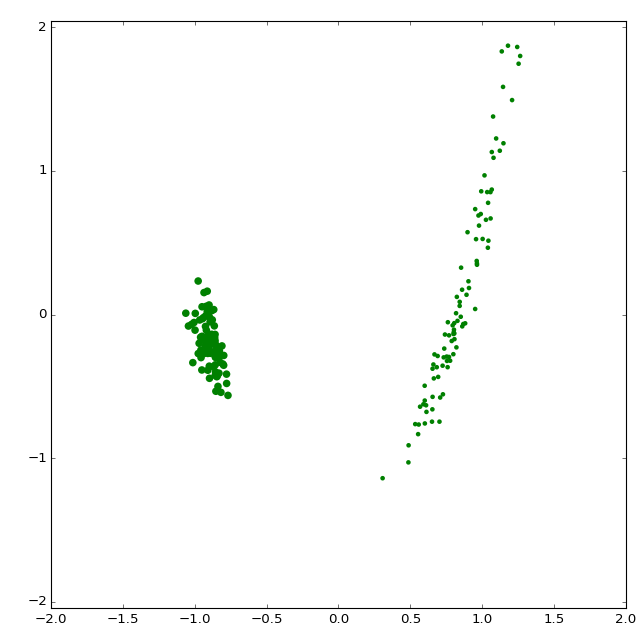

In [28]:
# To display our point cloud, we first have to turn our
# Pytorch variables (possibly GPU-enabled) into numpy arrays
w_d = W_d.data.cpu().numpy() ; x_d = X_d.data.cpu().numpy()

# We can then use standard matplotlib routines:
fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'g', edgecolors='none' )
plt.axis('equal')   ; plt.tight_layout()
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
fig.canvas.draw()

## The default model (starting point) v. our target dataset

In [29]:
# A "default" polynomial model of degree 3.
MyModel = GenerativeModel(degree = 3)
(W_t, X_t) = MyModel(NPOINTS)

<IPython.core.display.Javascript object>


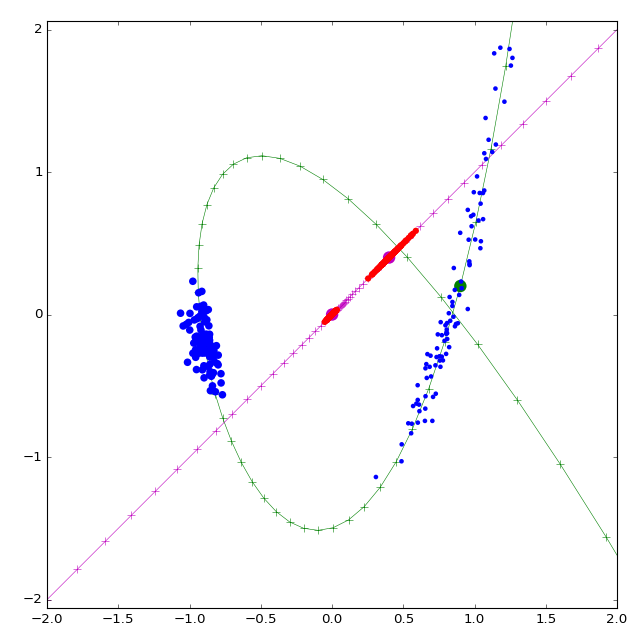

In [30]:
# Let's display it next to our "Ground Truth"!
w_d = W_d.data.cpu().numpy() ; x_d = X_d.data.cpu().numpy()
w_t = W_t.data.cpu().numpy() ; x_t = X_t.data.cpu().numpy()

fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
GroundTruth.plot(ax, 'g')
MyModel.plot(ax, 'm')
ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'b', edgecolors='none' )
ax.scatter( x_t[:,0], x_t[:,1], 6400*w_t, 'r', edgecolors='none' )

plt.axis('equal')   ; plt.tight_layout()
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
fig.canvas.draw()

## Get prepared for model optimization

In [31]:
def plot_situation(fig, ax, ground_truth,     mymodel, 
                            training_measure, generated_measure,
                            info_type,        info             ) :
    """
    During the model-fitting loop, plots the evolution of the
    trained model next to our "ground truth".
    """
    # Turn PyTorch variables into numpy arrays --------------------------
    w_d =  training_measure[0].data.cpu().numpy()
    x_d =  training_measure[1].data.cpu().numpy()
    w_t = generated_measure[0].data.cpu().numpy()
    x_t = generated_measure[1].data.cpu().numpy()
    
    # Remove the colorbar if any, clear the axis ------------------------
    if len(ax.images) > 0 :
        cbars = ax.images[0].colorbar
        if cbars is not None : 
            cbars.remove()
    ax.clear()
    
    # Plot the "info" image/transport-plan, if any ----------------------
    if info is not None :
        info  = info.data.cpu().numpy()
        if info_type == "heatmap" :     # The info is a signal defined on the plane
            # We display it as a background image
            scale = np.amax(np.abs(info)) * 1.5
            cax   = ax.imshow(info, interpolation='bilinear', origin='lower', 
                      vmin = -scale, vmax = scale, cmap=cm.bwr, 
                      extent=(-2,2, -2, 2), zorder=-2)
            cbar  = fig.colorbar(cax)
        elif info_type == "transport" : # The info is a transport plan between the two measures
            # We display it as a "spider's web" linking the training measure to the generated one.
            segs = []
            Q_weights,Q_points = w_t,x_t  ;  targetpoints = x_d
            # (the code below is here to produce fancy plots, no need to worry about it)
            for (a, mui, gi) in zip(Q_points, Q_weights, info) :
                #segs += [ [a, targetpoints[np.argmax(gi)] ] ]
                gi = gi / mui # gi[j] = fraction of the mass from "a" which goes to targetpoints[j]
                for (xj, gij) in zip(targetpoints, gi) :
                    mass_per_line = 0.02
                    if gij >= mass_per_line :
                        nlines = np.floor(gij / mass_per_line)
                        ts     = np.linspace(-.005*(nlines-1), .005*(nlines-1), nlines)
                        for t in ts :
                            b = xj + t*np.array([ xj[1]-a[1], -xj[0]+a[0]])
                            segs += [[a, b]]
                            
            line_segments = LineCollection(np.array(segs), linewidths=(.3,), 
                                           colors=[(.6,.8,1.)]*len(segs), linestyle='solid', zorder=-1)
            ax.add_collection(line_segments)
    
    # Plot the model "embeddings", and the associated point clouds ------
    ground_truth.plot(ax, 'g')
    mymodel.plot(ax, 'm')
    ax.scatter( x_d[:,0], x_d[:,1], 6400*w_d, 'b', edgecolors='none' )
    ax.scatter( x_t[:,0], x_t[:,1], 6400*w_t, 'r', edgecolors='none' )
    
    # Ready to plot ! ---------------------------------------------------
    plt.axis('equal')  ; plt.tight_layout() ; ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
    fig.canvas.draw()

In [32]:
def FitModel(Model, Fidelity, EmpiricMeasure, name = "model", info_type = "heatmap", **kwargs) :
    """
    Given an EmpiricMeasure (observed), and a Fidelity "error assessment formula"
    betweens measures, this routines fits an arbitrary generative Model
    to make it generate sample distributions close to the empirical one.
    """
    # We'll minimize "Fidelity( SampledModelDistribution, EmpiricMeasure )"
    # with respect to the model's parameters using a standard gradient-like
    # descent scheme.
    optimizer = torch.optim.Adam(Model.parameters(), lr = .05)
    
    # We'll plot results on-the-fly
    fig = plt.figure(figsize=(10,8)) ; ax  = plt.subplot(1,1,1)
    costs = [] ; N = len(EmpiricMeasure[0]) ; NLOG = 20
    
    FitModel.nit = -1
    def closure():
        "Encapsulates the problem + display."
        FitModel.nit += 1 ; i = FitModel.nit
        # Minimization loop --------------------------------------------------------------------
        optimizer.zero_grad()                      # Reset the gradients (PyTorch syntax...).
        GeneratedMeasure = Model(N)                # Draw a random sample from our model.
        Cost, info = Fidelity( GeneratedMeasure, EmpiricMeasure,  # Compute the discrepancy
                               info = (i%NLOG==0), **kwargs )     # wrt. the empirical distrib.
        costs.append(Cost.data.cpu().numpy()[0])   # Store the "cost" for plotting.
        Cost.backward(retain_graph=True)           # Backpropagate to compute the gradient.
        
        if i % NLOG == 0: # Display the current model ------------------------------------------
            print("Iteration ",i,"Cost = ", Cost.data.cpu().numpy()[0])
            plot_situation(fig, ax, GroundTruth,    Model, 
                                    EmpiricMeasure, GeneratedMeasure,
                                    info_type, info                   )
            fig.savefig('output/'+name+'_'+str(i)+'.png', dpi=fig.dpi) # -----------------------
        
        return Cost
    
    for i in range(401) :           # Fixed number of iterations
        optimizer.step(closure)     # "Gradient descent" step.
            
        
    # Once the minimization is over, display the cost evolution --------------------------------
    fig = plt.figure(figsize=(8,8)) ;  ax  = plt.subplot(1,1,1)
    ax.plot(np.array(costs))
    fig.canvas.draw()

## Using a kernel norm

In [33]:
def kernel_product(x,y,b, mode = "gaussian", s = 1.) :
    """
    Computes K(x_i,y_j) @ b_j = \sum_j k(x_i-y_j) * b_j
    where k is a kernel function (say, a Gaussian) of deviation s.
    """
    x_i = x.unsqueeze(1) ; y_j = y.unsqueeze(0) # We use PyTorch's broadcasting syntax
    xmy = ((x_i-y_j)**2).sum(2)                 # xmy[i,j] = |x_i-y_j|^2
    if   mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
    elif mode == "laplace"  : K = torch.exp( - torch.sqrt(xmy + (s**2)) )
    elif mode == "energy"   : K = torch.pow( xmy + (s**2), -.25 )
    return K @ (b.view(-1,1))

In [34]:
def kernel_scalar_product(Mu, Nu, mode = "gaussian", s = 1.) :
    """
    Takes as input two measures Mu and Nu,
    Mu = \sum_i mu_i*\delta_{x_i}  ; Nu = \sum_j nu_j*\delta_{y_j}
    
    as well as parameters for a kernel function.
    
    Computes the kernel scalar produc
    <Mu,Nu>_k = < Mu, k \star Nu >_{L^2}                   (convolution product)
              = \sum_{i,j} k(x_i-y_j) * mu_i * nu_j
    """
    (mu, x) = Mu ; (nu, y) = Nu
    k_nu = kernel_product(x,y,nu,mode,s)
    return torch.dot( mu.view(-1), k_nu.view(-1)) # PyTorch syntax for a scalar product...

In [35]:
def kernel_distance(Mu, Nu, info = False, mode = "gaussian", s = 1.) :
    """
    Hilbertian kernel distance between measures Mu and Nu,
    computed using the fact that
    
    |Mu-Nu|^2_k  =  <Mu,Mu>_k - 2 <Mu,Nu>_k + <Nu,Nu>_k
    
    If "info" is required, we output the values of
         k \star (Mu-Nu)  sampled on a uniform grid,
    to be plotted later.
    
    Strictly speaking, it would make more sense to display
         g \star (Mu-Nu)     where     g \star g = k
    as we would then have
          |Mu-Nu|^2_k  =  |g \star (Mu-Nu)|^2_{L^2}.
        
    But this is easy only for Gaussians...
    """
    D2 =   (   kernel_scalar_product(Mu,Mu,mode,s) \
           +   kernel_scalar_product(Nu,Nu,mode,s) \
           - 2*kernel_scalar_product(Mu,Nu,mode,s) )
    
    kernel_heatmap = None
    if info :
        # Create a uniform grid on the [-2,+2]x[-2,+2] square:
        res    = 100 ; ticks = np.linspace( -2, 2, res + 1)[:-1] + 1/(2*res) 
        X,Y    = np.meshgrid( ticks, ticks )
        points = Variable(torch.from_numpy(np.vstack( (X.ravel(), Y.ravel()) ).T).type(dtype), requires_grad=False)
        
        # Sample "k \star (Mu-Nu)" on this grid:
        kernel_heatmap   = kernel_product(points, Mu[1], Mu[0], mode, s) \
                         - kernel_product(points, Nu[1], Nu[0], mode, s)
        kernel_heatmap   = kernel_heatmap.view(res,res) # reshape as a "background" image
    return D2, kernel_heatmap

<IPython.core.display.Javascript object>


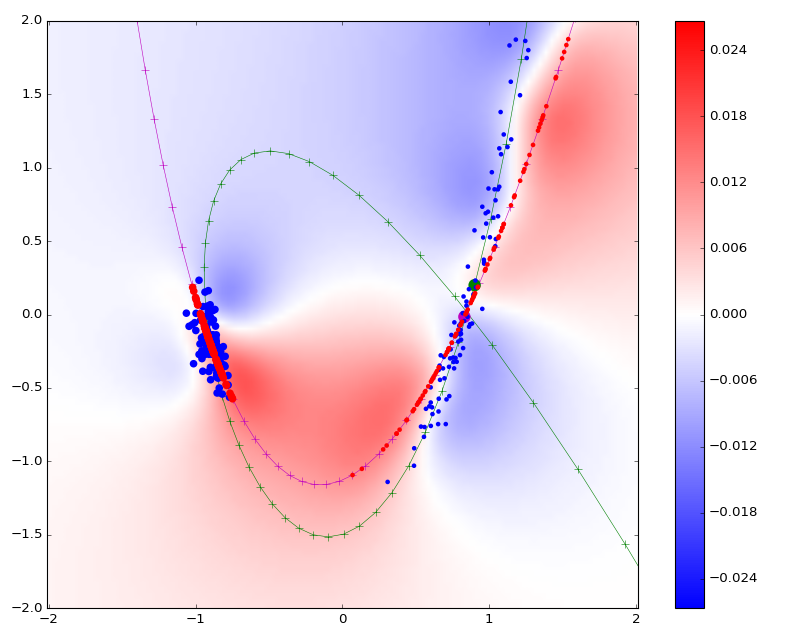

Iteration  0 Cost =  1.23377
Iteration  20 Cost =  0.148942
Iteration  40 Cost =  0.074492
Iteration  60 Cost =  0.0519722
Iteration  80 Cost =  0.0360415
Iteration  100 Cost =  0.0299349
Iteration  120 Cost =  0.0200341
Iteration  140 Cost =  0.0167971
Iteration  160 Cost =  0.0132713
Iteration  180 Cost =  0.0112793
Iteration  200 Cost =  0.015008
Iteration  220 Cost =  0.00954247
Iteration  240 Cost =  0.00775218
Iteration  260 Cost =  0.0173781
Iteration  280 Cost =  0.0062542
Iteration  300 Cost =  0.011446
Iteration  320 Cost =  0.00859666
Iteration  340 Cost =  0.00439334
Iteration  360 Cost =  0.0051744
Iteration  380 Cost =  0.0110548
Iteration  400 Cost =  0.00307202


<IPython.core.display.Javascript object>


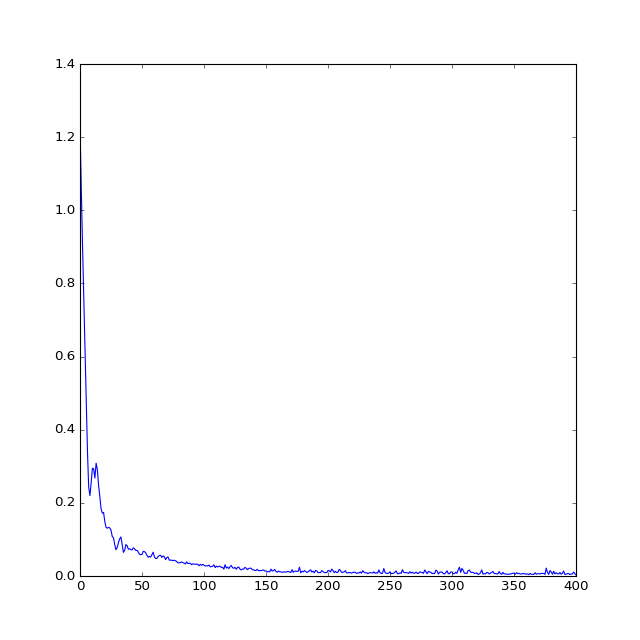

In [36]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, kernel_distance, (W_d, X_d), mode = "energy", s=.25)

## Using an Optimal Transport distance

In [37]:
def wasserstein_distance(Mu, Nu, info = False, mode = "gaussian", s = .2) :
    """
    Executes the Sinkhorn algorithm to compute an approximate Optimal Transport
    cost between Mu and Nu, using an entropic regularization of strength
    epsilon = s^2.
    """
    A = Variable(torch.ones(Mu[0].size()).type(dtype))
    B = Variable(torch.ones(Nu[0].size()).type(dtype))
    for it in range(1000) :
        A_prev = A
        A = Mu[0] / kernel_product(Mu[1], Nu[1], B,mode,s).view(-1)
        B = Nu[0] / kernel_product(Nu[1], Mu[1], A,mode,s).view(-1)
        err = (A.log()-A_prev.log()).abs().mean().data.cpu().numpy()
        #if err < 1e-5 :
        #    print(it, ": ", err, ", ", end="")
        #    break
        
    #D2 = kernel_scalar_product((A,Mu[1]), (B,Nu[1]), mode, s)
    eps = s**2
    D2_d = eps * ( torch.dot(Mu[0].view(-1), A.log().view(-1) + .5) \
                 + torch.dot(Nu[0].view(-1), B.log().view(-1) + .5) )
    
    x_i = Mu[1].unsqueeze(1) ; y_j = Nu[1].unsqueeze(0)
    xmy = ((x_i-y_j)**2).sum(2)
    if   mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
    elif mode == "laplace"  : K = torch.exp( - torch.sqrt(xmy + (s**2)) )
    elif mode == "energy"   : K = torch.pow( xmy + (s**2), -.25 )
    transport_plan = K * (A[0].view(-1,1) * B[0].view(1,-1))
    D2_p = eps * (transport_plan * xmy).sum()    
    
    print( (D2_p + D2_d).data.cpu().numpy() , ", ", end ="")
        
    transport_plan = None
    if info :
        x_i = Mu[1].unsqueeze(1) ; y_j = Nu[1].unsqueeze(0)
        xmy = ((x_i-y_j)**2).sum(2)
        if   mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
        elif mode == "laplace"  : K = torch.exp( - torch.sqrt(xmy + (s**2)) )
        elif mode == "energy"   : K = torch.pow( xmy + (s**2), -.25 )
        transport_plan = K #* (Mu[0].view(-1,1) * Nu[0].view(1,-1))
        print((transport_plan.sum(1)-Mu[0]).abs().mean() / (Mu[0].abs().mean()))
        print((transport_plan.sum(0)-Nu[0]).abs().mean() / (Nu[0].abs().mean()))
    return D2_p, transport_plan

In [38]:
#MyModel = GenerativeModel(degree = 2)
#FitModel(MyModel, wasserstein_distance, (W_d, X_d), 
#         info_type = "transport", name = "OT", mode="gaussian", s = .5)

## Sinkhorn  algorithm in the log domain

In [39]:
def log_sum_exp(mat, dim):
    max_rc = torch.max(mat, dim)[0]
    return max_rc + torch.log(torch.sum(torch.exp(mat - max_rc.unsqueeze(dim)), dim))

def wasserstein_distance_log(Mu, Nu, info = False, s = .2) :
    """
    Log-domain implementation of the Sinkhorn algorithm,
    for numerical stability.
    The "multiplicative" standard implementation is replaced
    by an "additive" logarithmic one, as:
    - A is replaced by U = eps * log(A)
    - B is replaced by V = eps * log(A)
    - K_ij is replaced by C_ij = - eps * log(K_ij)
                               = |X_i-Y_j|^2
    (remember that epsilon = eps = s^2)
    
    The update step:
    
    " a_i = mu_i / \sum_j k(x_i,y_j) b_j "
    
    is thus replaced, applying eps*log(...) on both sides, by
    
    " u_i = eps*[ log(mu_i) - log(sum( exp(-C_ij/eps) * exp(v_j/eps) )) ]
          = eps*[ log(mu_i) - log(sum( exp((v_j-C_ij)/eps ))            ]
          = eps*[ log(mu_i) - log(sum( exp((u_i+v_j-C_ij)/eps))) + u_i/eps  ]
    
    
    """
    U   = Variable(torch.zeros(Mu[0].size()).type(dtype))
    V   = Variable(torch.zeros(Nu[0].size()).type(dtype))
    C   = ((Mu[1].unsqueeze(1) - Nu[1].unsqueeze(0) )**2).sum(2)
    tau = -.5  # We use a slight extrapolation to go faster (this may let our algorithm diverge...)
    eps = s**2
    for it in range(1000) :
        U_prev = U
        U = tau*U + (1-tau)*eps*( torch.log(Mu[0]) - log_sum_exp( (V.view(1,-1) - C) / eps, dim=1 ).view(-1) )
        V = tau*V + (1-tau)*eps*( torch.log(Nu[0]) - log_sum_exp( (U.view(-1,1) - C) / eps, dim=0 ).view(-1) )
                 
        err = (U-U_prev).abs().mean().data.cpu().numpy()
        if err < 1e-5 :
            print(it, ", ", end="")
            break
         
    D2 = (( (U.view(-1,1)+V.view(1,-1) - C) / eps ).exp() * C).sum()
    transport_plan = None
    if info :
        transport_plan = ((U.view(-1,1)+V.view(1,-1) - C) / eps ).exp()
    return D2, transport_plan

<IPython.core.display.Javascript object>


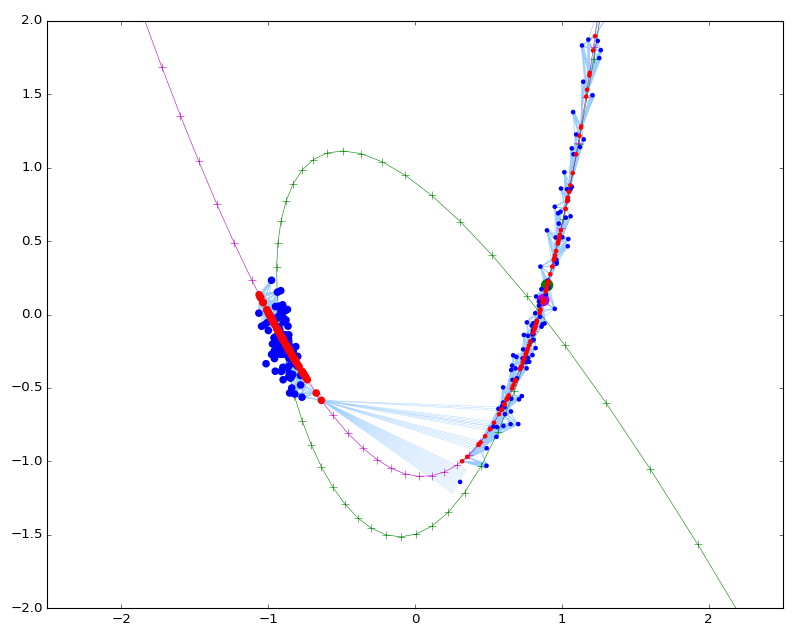

20 , Iteration  0 Cost =  1.20764


/home/jean/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


34 , 43 , 45 , 56 , 66 , 64 , 66 , 57 , 74 , 87 , 173 , 196 , 274 , 329 , 445 , 392 , 479 , Iteration  20 Cost =  0.181363
741 , 682 , 946 , 335 , 620 , 459 , 801 , 707 , 469 , 536 , 575 , 762 , 509 , 500 , 737 , Iteration  40 Cost =  0.0506632
701 , 486 , 758 , 751 , 752 , 700 , 916 , 923 , 852 , Iteration  60 Cost =  0.0349201
793 , 187 , Iteration  80 Cost =  0.0268447
862 , 117 , 187 , 838 , 766 , 806 , 996 , 907 , Iteration  100 Cost =  0.0358119
Iteration  120 Cost =  0.0286635
816 , Iteration  140 Cost =  0.0183695
147 , Iteration  160 Cost =  0.0230794
Iteration  180 Cost =  0.0312836
833 , Iteration  200 Cost =  0.0255395
Iteration  220 Cost =  0.0254255


In [ ]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, wasserstein_distance_log, (W_d, X_d), info_type = "transport", name = "wasserstein", s = .15)